In [1]:
#Read in standard packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd

In [14]:
#read in ML packages/modules
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
#Read in dask package and set up to allow for faster compute times. Distributes computing among all availabel preocessors
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:61674" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:61692, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:61691, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:61697, threads: 2>})

### Read in training/testing data

In [4]:
#Read in train/test data
train_X = pd.read_pickle('Data/train_test/train_X.pkl')
test_X = pd.read_pickle('Data/train_test/test_X.pkl')
train_y = pd.read_pickle('Data/train_test/train_y.pkl')
test_y = pd.read_pickle('Data/train_test/test_y.pkl')

In [5]:
train_y = train_y.map({'functional':2, 'non functional':0, 'functional needs repair':1})
test_y = test_y.map({'functional':2, 'non functional':0, 'functional needs repair':1})

# ADABoost Classifier

ADABoost is meant to use other classisfers as a base and weight incorrect responses higher as it moves through it's iterations. We will use two different types of models, Random Forest, Logistic Regression, as bases and see if we can inch up the accuracy a little bit higher.

In [6]:
#this out of the box version uses simple decision trees
ada = AdaBoostClassifier()
with joblib.parallel_backend('dask'):
    ada.fit(train_X, train_y)
ada.score(test_X, test_y)

0.725993265993266

In [7]:
#Create dataframe to store metrics and parameters
ada_deets = pd.DataFrame(ada.get_params(), index=['ADA_OBO'])
ada_deets.insert(0, value=ada.score(test_X, test_y), column='Accuracy')
ada_deets

,Accuracy,algorithm,base_estimator,learning_rate,n_estimators,random_state
ADA_OBO,0.725993,SAMME.R,None,1.0,50,None


This performs pretty well. WWe can further tune some hyperparamters to possibly get higher accuracy. Let's start with class weights. But we need to first save the parameters and score for later review.

In [8]:
#Run ADABoost with Random Forest base
rf = RandomForestClassifier(n_estimators=50, criterion='gini', class_weight='balanced_subsample')
ada_rf50 = AdaBoostClassifier(base_estimator=rf)
with joblib.parallel_backend('dask'):
    ada_rf50.fit(train_X, train_y)
ada_rf50.score(test_X, test_y)

0.8004713804713804

In [9]:
#Store metrics and parameters
a = ada_rf50.get_params()
a['Accuracy'] = ada_rf50.score(test_X, test_y)
ada_deets = pd.concat([ada_deets, pd.DataFrame(a, index=['ADA_RF50'])], axis=0, join='outer')
ada_deets

,Accuracy,algorithm,base_estimator,learning_rate,n_estimators,random_state,base_estimator__bootstrap,base_estimator__ccp_alpha,base_estimator__class_weight,base_estimator__criterion,...,base_estimator__min_impurity_split,base_estimator__min_samples_leaf,base_estimator__min_samples_split,base_estimator__min_weight_fraction_leaf,base_estimator__n_estimators,base_estimator__n_jobs,base_estimator__oob_score,base_estimator__random_state,base_estimator__verbose,base_estimator__warm_start
ADA_OBO,0.725993,SAMME.R,None,1.0,50,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADA_RF50,0.800471,SAMME.R,RandomForestClassifier(class_weight='balanced_...,1.0,50,None,True,0.0,balanced_subsample,gini,...,None,1.0,2.0,0.0,50.0,None,False,None,0.0,False


This does about as well as our typical Random Forest. 

In [10]:
#RUn ADABoost using Logistic Regression as base 
logi_f = LogisticRegression(penalty='l2', C=10, verbose=True, solver='liblinear')
ada_lr = AdaBoostClassifier(base_estimator=logi_f)
ada_lr.fit(train_X, train_y)
ada_lr.score(test_X, test_y)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

0.7453872053872054

In [11]:
#Store metrics and parameters
a = ada_lr.get_params()
a['Accuracy'] = ada_lr.score(test_X, test_y)
ada_deets = pd.concat([ada_deets, pd.DataFrame(a, index=['ADA_LR'])], axis=0, join='outer')
ada_deets

,Accuracy,algorithm,base_estimator,learning_rate,n_estimators,random_state,base_estimator__bootstrap,base_estimator__ccp_alpha,base_estimator__class_weight,base_estimator__criterion,...,base_estimator__C,base_estimator__dual,base_estimator__fit_intercept,base_estimator__intercept_scaling,base_estimator__l1_ratio,base_estimator__max_iter,base_estimator__multi_class,base_estimator__penalty,base_estimator__solver,base_estimator__tol
ADA_OBO,0.725993,SAMME.R,None,1.0,50,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADA_RF50,0.800471,SAMME.R,RandomForestClassifier(class_weight='balanced_...,1.0,50,None,True,0.0,balanced_subsample,gini,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADA_LR,0.745387,SAMME.R,"LogisticRegression(C=10, solver='liblinear', v...",1.0,50,None,NaN,NaN,None,NaN,...,10.0,False,True,1.0,None,100.0,auto,l2,liblinear,0.0001


We are actually seeing a reduction in accuracy. It may be that more hyperparameter tuning is necessary to truly see a benefit with the linear model boosting.

<Figure size 2880x576 with 0 Axes>

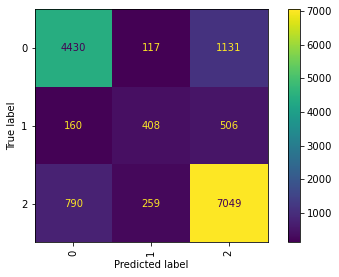

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      5678
           1       0.52      0.38      0.44      1074
           2       0.81      0.87      0.84      8098

    accuracy                           0.80     14850
   macro avg       0.72      0.68      0.69     14850
weighted avg       0.80      0.80      0.80     14850



In [21]:
#Create visualization of class metrics using best model (Random Forest base) via confusion matrix and classification report
y_pred = ada_rf50.predict(test_X)
cm=confusion_matrix(test_y, y_pred, labels=ada_rf50.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=ada_rf50.classes_)
plt.figure(figsize=(40,8))
disp.plot()
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()
print(classification_report(test_y, y_pred, labels=ada_rf50.classes_))

In [22]:
#Do to long computation times we won't run cross validation at this time.
#print(cross_val_score(ada_f, train_X, train_y, cv=5))

In [23]:
#Output for comparision
ada_deets.to_pickle('Data/scores/ADA.pkl')